## Prepare mesh

In [1]:
!gmsh circle.geo -setnumber geomtype 2 -o circle_vacuum_metal_vacuum.msh -2 >& /dev/null
!convert_msh.py circle_vacuum.msh circle_vacuum.xdmf
!gmsh circle.geo -setnumber geomtype 2 -o circle_vacuum_metal_vacuum.msh -2 >& /dev/null
!convert_msh.py circle_vacuum_metal.msh circle_vacuum_metal.xdmf
!gmsh circle.geo -setnumber geomtype 2 -o circle_vacuum_metal_vacuum.msh -2 >& /dev/null
!convert_msh.py circle_vacuum_metal_vacuum.msh circle_vacuum_metal_vacuum.xdmf

!gmsh ellipse.geo -setnumber geomtype 2 -o ellipse_vacuum_metal_vacuum.msh -2 >& /dev/null
!convert_msh.py ellipse_vacuum.msh ellipse_vacuum.xdmf
!gmsh ellipse.geo -setnumber geomtype 2 -o ellipse_vacuum_metal_vacuum.msh -2 >& /dev/null
!convert_msh.py ellipse_vacuum_metal.msh ellipse_vacuum_metal.xdmf
!gmsh ellipse.geo -setnumber geomtype 2 -o ellipse_vacuum_metal_vacuum.msh -2 >& /dev/null
!convert_msh.py ellipse_vacuum_metal_vacuum.msh ellipse_vacuum_metal_vacuum.xdmf

## Solution preparation

In [2]:
import logging
import bi2d
from bi2d.materials import vacuum, beam
import numpy as np
import gc

Using steel for SIBC

In [3]:
beam.index = 1
vacuum.index = 2
steel = bi2d.Material(3, sigma=1e6)
wall = steel.copy()
wall.index = -1
outer_vacuum = vacuum.copy()
outer_vacuum.index = 4

Setup mesh and materials

In [4]:
circle_m_v = bi2d.Mesh("circle_vacuum.xdmf")
circle_m_vm = bi2d.Mesh("circle_vacuum_metal.xdmf")
circle_m_vmv = bi2d.Mesh("circle_vacuum_metal_vacuum.xdmf")
circle_mc_v = bi2d.MaterialMap(circle_m_v, [beam, vacuum])
circle_mc_vm = bi2d.MaterialMap(circle_m_vm, [beam, vacuum, steel])
circle_mc_vmv = bi2d.MaterialMap(circle_m_vmv, [beam, vacuum, steel, outer_vacuum])
ellipse_m_v = bi2d.Mesh("ellipse_vacuum.xdmf")
ellipse_m_vm = bi2d.Mesh("ellipse_vacuum_metal.xdmf")
ellipse_m_vmv = bi2d.Mesh("ellipse_vacuum_metal_vacuum.xdmf")
ellipse_mc_v = bi2d.MaterialMap(ellipse_m_v, [beam, vacuum])
ellipse_mc_vm = bi2d.MaterialMap(ellipse_m_vm, [beam, vacuum, steel])
ellipse_mc_vmv = bi2d.MaterialMap(ellipse_m_vmv, [beam, vacuum, steel, outer_vacuum])

In [5]:
(minx, miny), (maxx, maxy) = circle_m_v.get_limits(1)
print(f"Circle beam radius: {(maxx-minx)/2*1e3} [mm]")
(minx, miny), (maxx, maxy) = circle_m_v.get_limits(2)
print(f"Circle radius: {(maxx-minx)/2*1e3} [mm]")
(minx, miny), (maxx, maxy) = ellipse_m_v.get_limits(1)
print(f"Ellipse beam radius: {(maxx-minx)/2*1e3} [mm]")
(minx, miny), (maxx, maxy) = ellipse_m_v.get_limits(2)
ellipse_x = (maxx-minx)/2
ellipse_y = (maxy-miny)/2
print(f"Ellipse radius: {ellipse_x*1e3}x{ellipse_y*1e3} [mm]")

Circle beam radius: 1.0 [mm]
Circle radius: 10.0 [mm]
Ellipse beam radius: 1.0 [mm]
Ellipse radius: 14.0x10.0 [mm]


Configure solution

In [6]:
solution_circle_v = bi2d.Solution(circle_mc_v, Hcurl_order=2, H1_order=2)
solution_circle_vm = bi2d.Solution(circle_mc_vm, Hcurl_order=2, H1_order=2)
solution_ellipse_v = bi2d.Solution(ellipse_mc_v, Hcurl_order=2, H1_order=2)
solution_ellipse_vm = bi2d.Solution(ellipse_mc_vm, Hcurl_order=2, H1_order=2)

## Calculate impedance

### Monopole

In [7]:
%%time

circle_metal_solution_monopole = solution_circle_vm.get_z(np.logspace(3, 8, num=100), beta=0.999999, source_function=bi2d.SourceFunction.MONOPOLE)
ellipse_metal_solution_monopole = solution_ellipse_vm.get_z(np.logspace(3, 8, num=100), beta=0.999999, source_function=bi2d.SourceFunction.MONOPOLE)

CPU times: user 3h 8min 15s, sys: 6min, total: 3h 14min 15s
Wall time: 3h 14min 29s


These calculations are quite heavy. Free memory

In [8]:
del solution_circle_vm
del solution_ellipse_vm
gc.collect()

5936

In [9]:
%%time

circle_sibc_solution_monopole = solution_circle_v.get_z(np.logspace(6, 13, num=100), beta=0.999999, source_function=bi2d.SourceFunction.MONOPOLE, sibc=[wall])
ellipse_sibc_solution_monopole = solution_ellipse_v.get_z(np.logspace(6, 13, num=100), beta=0.999999, source_function=bi2d.SourceFunction.MONOPOLE, sibc=[wall])

CPU times: user 20min 34s, sys: 34.1 s, total: 21min 8s
Wall time: 21min 14s


In [10]:
del solution_circle_v
del solution_ellipse_v
gc.collect()

4835

In [11]:
iw2d_monopole = np.genfromtxt("ZlongWthin_pipe_2layers10.00mm_0_999999beta.dat", skip_header=1)

In [12]:
import pylab
pylab.rcParams['figure.figsize'] = [12, 8]

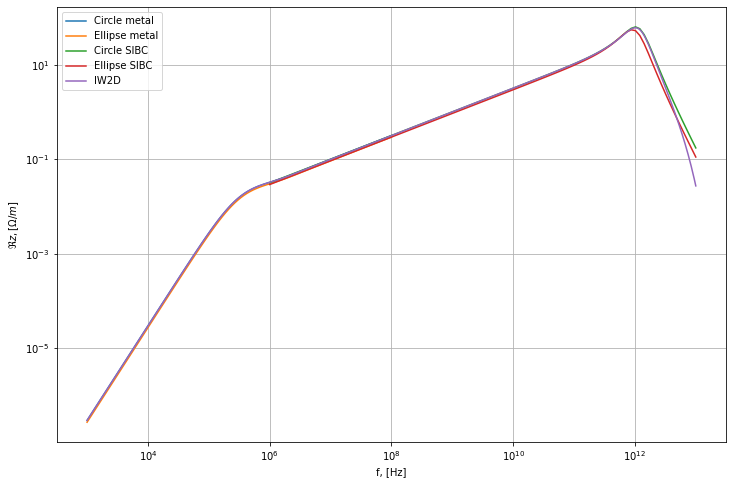

In [13]:
pylab.plot(circle_metal_solution_monopole[:,0], circle_metal_solution_monopole[:,1])
pylab.plot(ellipse_metal_solution_monopole[:,0], ellipse_metal_solution_monopole[:,1])
pylab.plot(circle_sibc_solution_monopole[:,0], circle_sibc_solution_monopole[:,1])
pylab.plot(ellipse_sibc_solution_monopole[:,0], ellipse_sibc_solution_monopole[:,1])
pylab.plot(iw2d_monopole[:,0], iw2d_monopole[:,1])
pylab.yscale("log")
pylab.xscale("log")
pylab.xlabel("f, [Hz]")
pylab.ylabel(r"$\Re{z}, [\Omega/m]$")
pylab.grid()
pylab.legend(["Circle metal", "Ellipse metal", "Circle SIBC", "Ellipse SIBC", "IW2D"])
pylab.show()

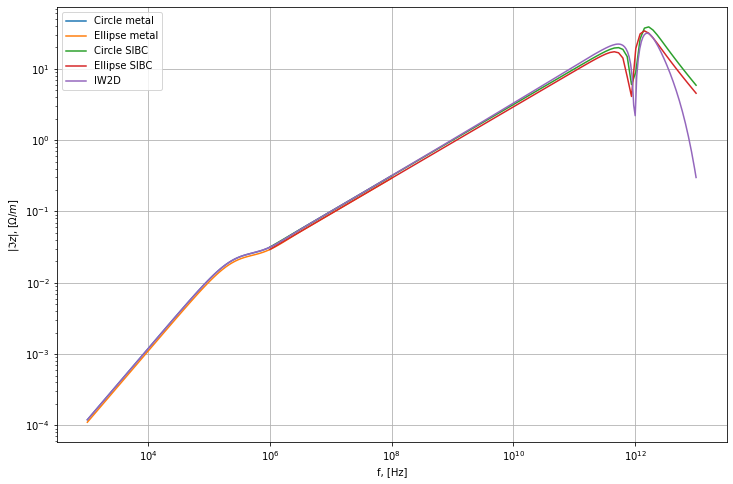

In [14]:
pylab.plot(circle_metal_solution_monopole[:,0], np.abs(circle_metal_solution_monopole[:,2]))
pylab.plot(ellipse_metal_solution_monopole[:,0], np.abs(ellipse_metal_solution_monopole[:,2]))
pylab.plot(circle_sibc_solution_monopole[:,0], np.abs(circle_sibc_solution_monopole[:,2]))
pylab.plot(ellipse_sibc_solution_monopole[:,0], np.abs(ellipse_sibc_solution_monopole[:,2]))
pylab.plot(iw2d_monopole[:,0], np.abs(iw2d_monopole[:,2]))
pylab.yscale("log")
pylab.xscale("log")
pylab.xlabel("f, [Hz]")
pylab.ylabel(r"$|\Im{z}|, [\Omega/m]$")
pylab.grid()
pylab.legend(["Circle metal", "Ellipse metal", "Circle SIBC", "Ellipse SIBC", "IW2D"])
pylab.show()

In [15]:
solution_circle_v = bi2d.Solution(circle_mc_v, Hcurl_order=2, H1_order=2)
solution_circle_vmv = bi2d.Solution(circle_mc_vmv, Hcurl_order=2, H1_order=2)
solution_ellipse_v = bi2d.Solution(ellipse_mc_v, Hcurl_order=2, H1_order=2)
solution_ellipse_vmv = bi2d.Solution(ellipse_mc_vmv, Hcurl_order=2, H1_order=2)

### Dipole rotation $0$

In [16]:
%%time

circle_metal_solution_dipole_0 = solution_circle_vmv.get_z(np.logspace(3, 8, num=100), beta=0.999999, source_function=bi2d.SourceFunction.DIPOLE)
ellipse_metal_solution_dipole_0 = solution_ellipse_vmv.get_z(np.logspace(3, 8, num=100), beta=0.999999, source_function=bi2d.SourceFunction.DIPOLE)

CPU times: user 3h 29min 5s, sys: 6min 26s, total: 3h 35min 31s
Wall time: 3h 36min 2s


In [17]:
del solution_circle_vmv
del solution_ellipse_vmv
gc.collect()

4246

In [18]:
%%time

circle_sibc_solution_dipole_0 = solution_circle_v.get_z(np.logspace(6, 13, num=100), beta=0.999999, source_function=bi2d.SourceFunction.DIPOLE, sibc=[wall])
ellipse_sibc_solution_dipole_0 = solution_ellipse_v.get_z(np.logspace(6, 13, num=100), beta=0.999999, source_function=bi2d.SourceFunction.DIPOLE, sibc=[wall])

CPU times: user 20min 53s, sys: 34 s, total: 21min 27s
Wall time: 21min 35s


In [19]:
del solution_circle_v
del solution_ellipse_v
gc.collect()

3665

In [20]:
iw2d_dipole = np.genfromtxt("ZxdipWthin_pipe_2layers10.00mm_0_999999beta.dat", skip_header=1)

In [21]:
formfactor = np.genfromtxt("formfactor.csv", skip_header=1, delimiter=",")
ellipse_ratio = (ellipse_x - ellipse_y) / ((ellipse_x + ellipse_y))
ellipse_formfactor_x = np.interp([ellipse_ratio], formfactor[:,0], formfactor[:,2])[0]
ellipse_formfactor_y = np.interp([ellipse_ratio], formfactor[:,0], formfactor[:,1])[0]

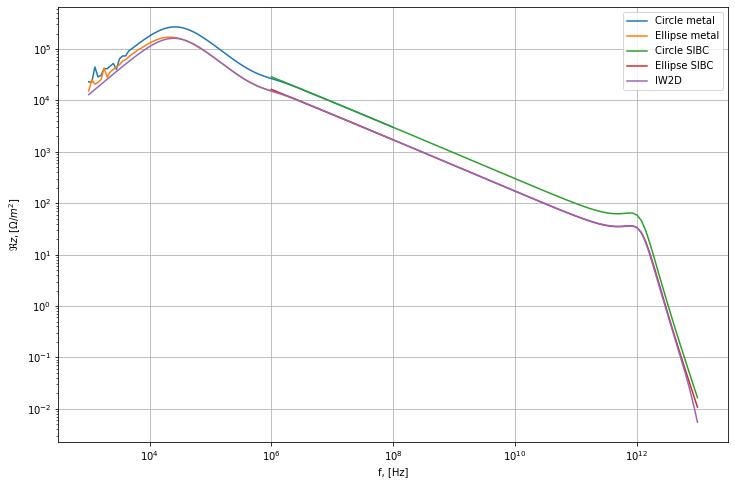

In [22]:
pylab.plot(circle_metal_solution_dipole_0[:,0], circle_metal_solution_dipole_0[:,1])
pylab.plot(ellipse_metal_solution_dipole_0[:,0], ellipse_metal_solution_dipole_0[:,1])
pylab.plot(circle_sibc_solution_dipole_0[:,0], circle_sibc_solution_dipole_0[:,1])
pylab.plot(ellipse_sibc_solution_dipole_0[:,0], ellipse_sibc_solution_dipole_0[:,1])
pylab.plot(iw2d_dipole[:,0], ellipse_formfactor_x * np.abs(iw2d_dipole[:,1]))
pylab.yscale("log")
pylab.xscale("log")
pylab.xlabel("f, [Hz]")
pylab.ylabel(r"$\Re{z}, [\Omega/m^2]$")
pylab.grid()
pylab.legend(["Circle metal", "Ellipse metal", "Circle SIBC", "Ellipse SIBC", "IW2D"])
pylab.show()

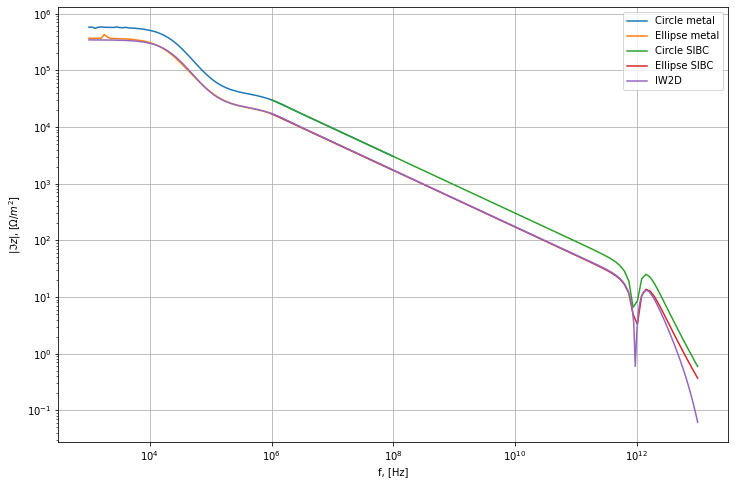

In [23]:
pylab.plot(circle_metal_solution_dipole_0[:,0], np.abs(circle_metal_solution_dipole_0[:,2]))
pylab.plot(ellipse_metal_solution_dipole_0[:,0], np.abs(ellipse_metal_solution_dipole_0[:,2]))
pylab.plot(circle_sibc_solution_dipole_0[:,0], np.abs(circle_sibc_solution_dipole_0[:,2]))
pylab.plot(ellipse_sibc_solution_dipole_0[:,0], np.abs(ellipse_sibc_solution_dipole_0[:,2]))
pylab.plot(iw2d_dipole[:,0], ellipse_formfactor_x * np.abs(iw2d_dipole[:,2]))
pylab.yscale("log")
pylab.xscale("log")
pylab.xlabel("f, [Hz]")
pylab.ylabel(r"$|\Im{z}|, [\Omega/m^2]$")
pylab.grid()
pylab.legend(["Circle metal", "Ellipse metal", "Circle SIBC", "Ellipse SIBC", "IW2D"])
pylab.show()

In [24]:
solution_circle_v = bi2d.Solution(circle_mc_v, Hcurl_order=2, H1_order=2)
solution_circle_vmv = bi2d.Solution(circle_mc_vmv, Hcurl_order=2, H1_order=2)
solution_ellipse_v = bi2d.Solution(ellipse_mc_v, Hcurl_order=2, H1_order=2)
solution_ellipse_vmv = bi2d.Solution(ellipse_mc_vmv, Hcurl_order=2, H1_order=2)

### Dipole rotation $90^\circ$

In [25]:
%%time

circle_metal_solution_dipole_90 = solution_circle_vmv.get_z(np.logspace(3, 8, num=100), beta=0.999999, rotation=np.pi/2, source_function=bi2d.SourceFunction.DIPOLE)
ellipse_metal_solution_dipole_90 = solution_ellipse_vmv.get_z(np.logspace(3, 8, num=100), beta=0.999999, rotation=np.pi/2, source_function=bi2d.SourceFunction.DIPOLE)

CPU times: user 3h 28min 29s, sys: 6min 16s, total: 3h 34min 45s
Wall time: 3h 35min 16s


In [26]:
del solution_circle_vmv
del solution_ellipse_vmv
gc.collect()

21920

In [27]:
%%time

circle_sibc_solution_dipole_90 = solution_circle_v.get_z(np.logspace(6, 13, num=100), beta=0.999999, rotation=np.pi/2, source_function=bi2d.SourceFunction.DIPOLE, sibc=[wall])
ellipse_sibc_solution_dipole_90 = solution_ellipse_v.get_z(np.logspace(6, 13, num=100), beta=0.999999, rotation=np.pi/2, source_function=bi2d.SourceFunction.DIPOLE, sibc=[wall])

CPU times: user 20min 56s, sys: 34 s, total: 21min 30s
Wall time: 21min 37s


In [28]:
del solution_circle_v
del solution_ellipse_v
gc.collect()

4795

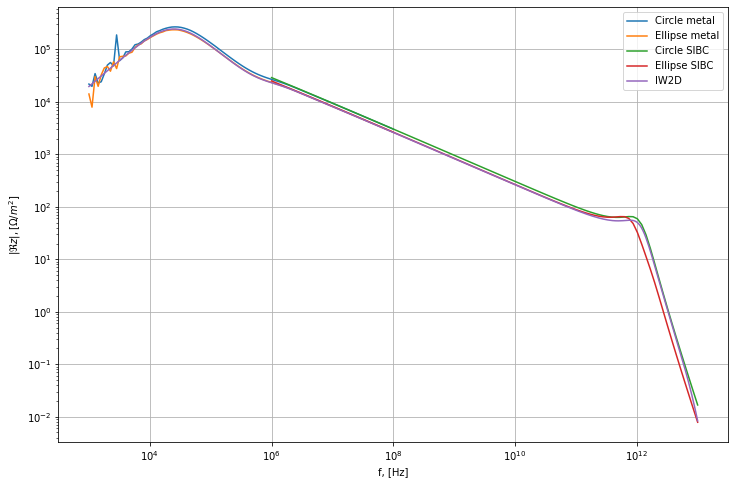

In [29]:
pylab.plot(circle_metal_solution_dipole_90[:,0], np.abs(circle_metal_solution_dipole_90[:,1]))
pylab.plot(ellipse_metal_solution_dipole_90[:,0], np.abs(ellipse_metal_solution_dipole_90[:,1]))
pylab.plot(circle_sibc_solution_dipole_90[:,0], np.abs(circle_sibc_solution_dipole_90[:,1]))
pylab.plot(ellipse_sibc_solution_dipole_90[:,0], np.abs(ellipse_sibc_solution_dipole_90[:,1]))
pylab.plot(iw2d_dipole[:,0], ellipse_formfactor_y * np.abs(iw2d_dipole[:,1]))
pylab.yscale("log")
pylab.xscale("log")
pylab.xlabel("f, [Hz]")
pylab.ylabel(r"$|\Re{z}|, [\Omega/m^2]$")
pylab.grid()
pylab.legend(["Circle metal", "Ellipse metal", "Circle SIBC", "Ellipse SIBC", "IW2D"])
pylab.show()

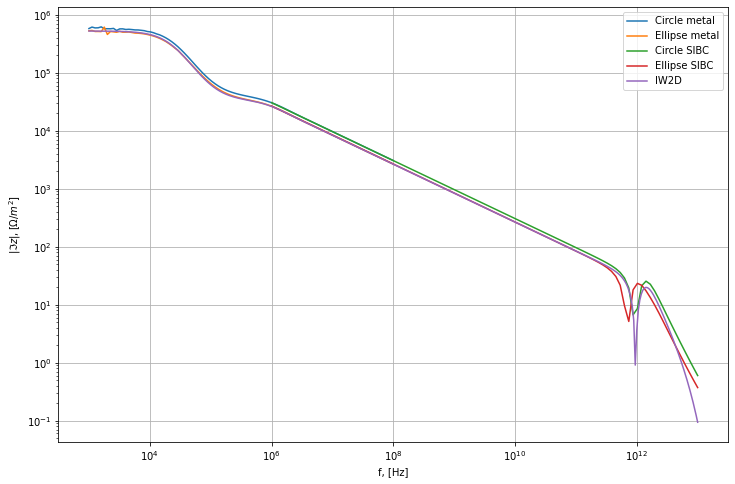

In [30]:
pylab.plot(circle_metal_solution_dipole_90[:,0], np.abs(circle_metal_solution_dipole_90[:,2]))
pylab.plot(ellipse_metal_solution_dipole_90[:,0], np.abs(ellipse_metal_solution_dipole_90[:,2]))
pylab.plot(circle_sibc_solution_dipole_90[:,0], np.abs(circle_sibc_solution_dipole_90[:,2]))
pylab.plot(ellipse_sibc_solution_dipole_90[:,0], np.abs(ellipse_sibc_solution_dipole_90[:,2]))
pylab.plot(iw2d_dipole[:,0], ellipse_formfactor_y * np.abs(iw2d_dipole[:,2]))
pylab.yscale("log")
pylab.xscale("log")
pylab.xlabel("f, [Hz]")
pylab.ylabel(r"$|\Im{z}|, [\Omega/m^2]$")
pylab.grid()
pylab.legend(["Circle metal", "Ellipse metal", "Circle SIBC", "Ellipse SIBC", "IW2D"])
pylab.show()